In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Load CIFAR-10 data
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

# Split training data into train (40k) and validation (10k)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42
)

# Normalize pixel values to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

def train_model(model, name):
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    history = model.fit(
        x_train, y_train,
        epochs=10,
        validation_data=(x_val, y_val),
        batch_size=64,
        verbose=0
    )

    y_pred_probs = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = y_test.flatten()

    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"{name} - Macro F1-score: {f1:.4f}")

    return history, f1


def plot_loss(histories, labels):
    plt.figure(figsize=(14, 6))
    for h, label in zip(histories, labels):
        plt.plot(h.history['loss'], label=f'{label} Train Loss')
        plt.plot(h.history['val_loss'], linestyle='--', label=f'{label} Val Loss')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()



##1. Pengujian Jumlah Layer Konvolusi

1 Conv Layer - Macro F1-score: 0.3587
2 Conv Layers - Macro F1-score: 0.4789
3 Conv Layers - Macro F1-score: 0.5821


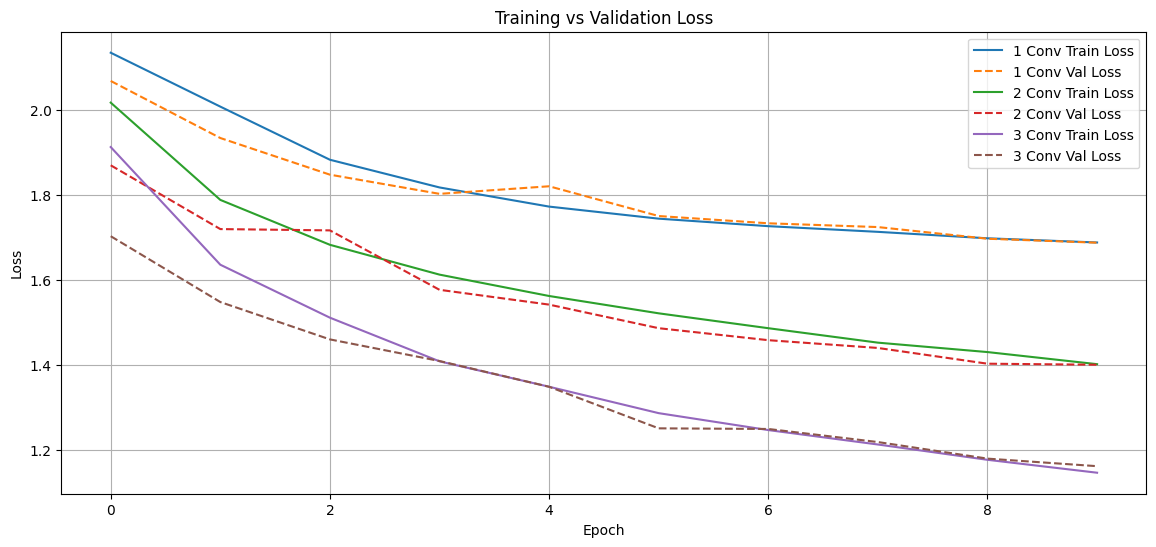

In [11]:
def build_model_conv_layers(num_conv):
    model = models.Sequential()
    model.add(layers.Input(shape=(32, 32, 3)))
    for i in range(num_conv):
        model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

# Definisikan model dengan 1, 2, dan 3 layer konvolusi
model1 = build_model_conv_layers(1)
model2 = build_model_conv_layers(2)
model3 = build_model_conv_layers(3)

# Train model
hist1, acc1 = train_model(model1, "1 Conv Layer")
hist2, acc2 = train_model(model2, "2 Conv Layers")
hist3, acc3 = train_model(model3, "3 Conv Layers")

# Plot lossnya
plot_loss([hist1, hist2, hist3], ["1 Conv", "2 Conv", "3 Conv"])



##2. Pengujian Jumlah Filter Per Layer Konvolusi

16-32 Filter - Macro F1-score: 0.4640
32-64 Filter - Macro F1-score: 0.4919
64-128 Filter - Macro F1-score: 0.5316


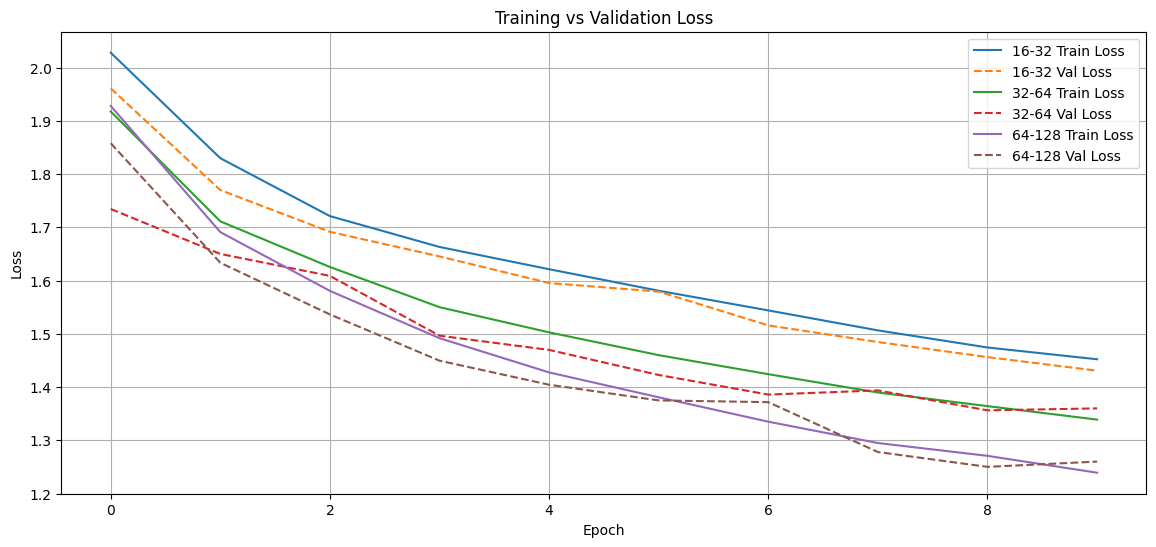

In [12]:
def build_model_filters(filter_list):
    model = models.Sequential()
    model.add(layers.Input(shape=(32, 32, 3)))
    for filters in filter_list:
        model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

model_a = build_model_filters([16, 32])
model_b = build_model_filters([32, 64])
model_c = build_model_filters([64, 128])

hist_a, acc_a = train_model(model_a, "16-32 Filter")
hist_b, acc_b = train_model(model_b, "32-64 Filter")
hist_c, acc_c = train_model(model_c, "64-128 Filter")

plot_loss([hist_a, hist_b, hist_c], ["16-32", "32-64", "64-128"])



##3. Pengujian Ukuran Filter

5x5 Kernel - Macro F1-score: 0.5673
10x10Kernel - Macro F1-score: 0.5695
20x20 Kernel - Macro F1-score: 0.5262


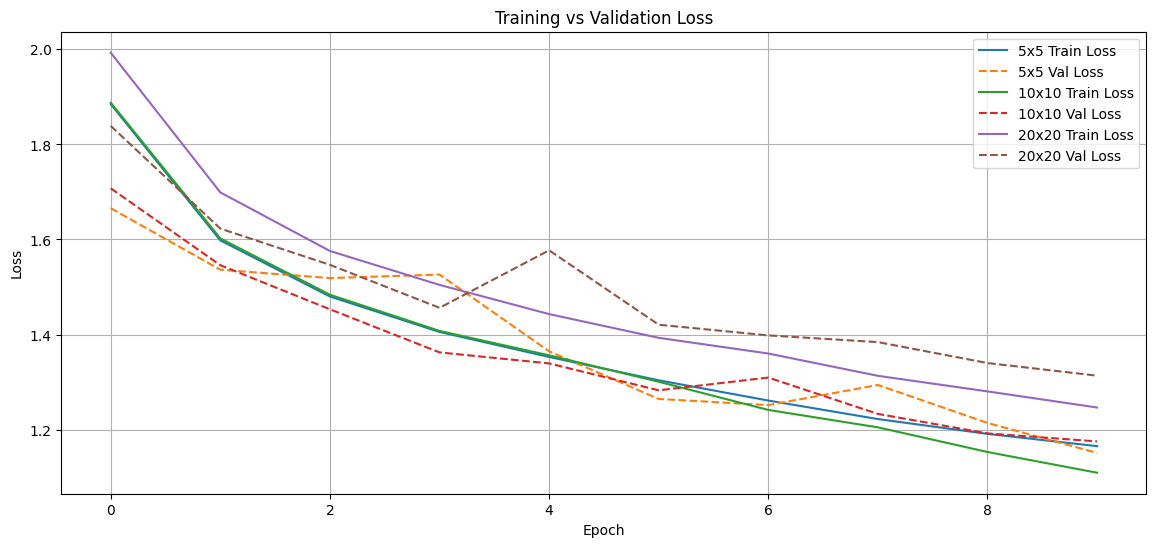

In [13]:
def build_model_kernel(kernel_size):
    model = models.Sequential()
    model.add(layers.Input(shape=(32, 32, 3)))
    model.add(layers.Conv2D(32, kernel_size, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, kernel_size, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model


model_k1 = build_model_kernel((5, 5))
model_k2 = build_model_kernel((10, 10))
model_k3 = build_model_kernel((20, 20))

hist_k1, acc_k1 = train_model(model_k1, "5x5 Kernel")
hist_k2, acc_k2 = train_model(model_k2, "10x10Kernel")
hist_k3, acc_k3 = train_model(model_k3, "20x20 Kernel")

plot_loss([hist_k1, hist_k2, hist_k3], ["5x5", "10x10", "20x20"])


##4. Pengujian Jenis Pooling

Max Pooling - Macro F1-score: 0.5098
Avg Pooling - Macro F1-score: 0.4377


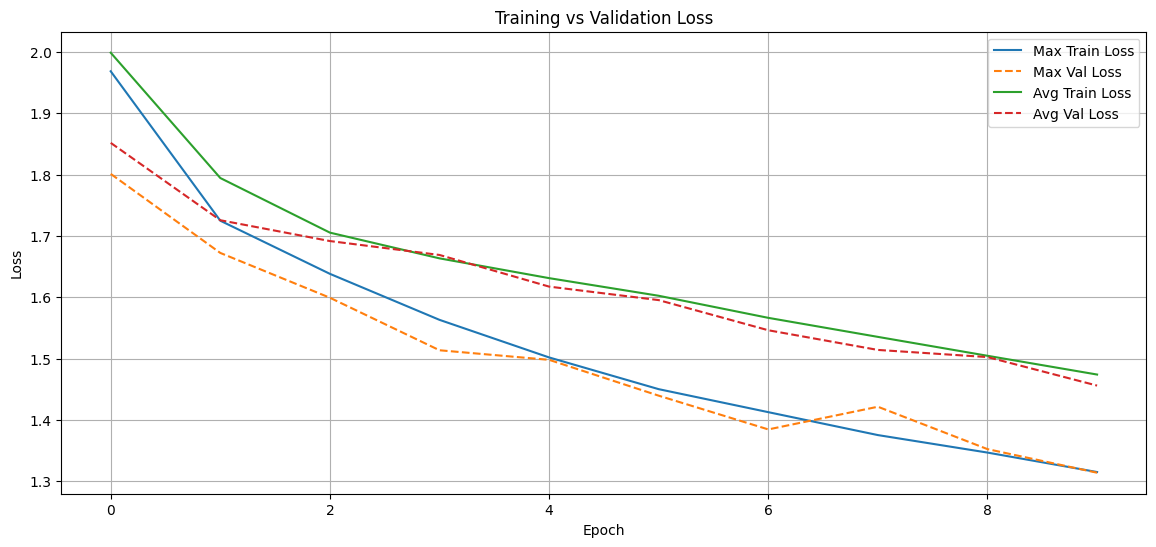

In [14]:
def build_model_pooling(pooling='max'):
    model = models.Sequential()
    model.add(layers.Input(shape=(32, 32, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    if pooling == 'max':
        model.add(layers.MaxPooling2D((2, 2)))
    else:
        model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    if pooling == 'max':
        model.add(layers.MaxPooling2D((2, 2)))
    else:
        model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

model_max = build_model_pooling('max')
model_avg = build_model_pooling('avg')

hist_max, acc_max = train_model(model_max, "Max Pooling")
hist_avg, acc_avg = train_model(model_avg, "Avg Pooling")

plot_loss([hist_max, hist_avg], ["Max", "Avg"])


#Forward Propagation Implementation

###Forward propagation with keras library

In [ ]:
modelKeras = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

train_model(modelKeras, "Model Keras" )

modelKeras.save_weights('modelKeras_weights.h5')



###Forward Propagation Implementation From Scratch

In [16]:
import h5py

def load_weights_from_keras(file_path):
    weights = {}
    with h5py.File(file_path, 'r') as f:
        for layer in f['model_weights']:
            layer_group = f['model_weights'][layer]
            for weight_name in layer_group:
                weights_key = f"{layer}/{weight_name}"
                weights[weights_key] = layer_group[weight_name][()]
    return weights


def conv2d_forward(x, weight, bias, stride=1):
    out_channels, in_channels, kh, kw = weight.shape
    h, w, _ = x.shape
    out_h = (h - kh) // stride + 1
    out_w = (w - kw) // stride + 1
    out = np.zeros((out_h, out_w, out_channels))

    for oc in range(out_channels):
        for i in range(out_h):
            for j in range(out_w):
                patch = x[i*stride:i*stride+kh, j*stride:j*stride+kw, :]
                out[i, j, oc] = np.sum(patch * weight[oc].transpose(1,2,0)) + bias[oc]
    return np.maximum(0, out)  # ReLU

def max_pool2d(x, size=2, stride=2):
    h, w, c = x.shape
    out_h = (h - size) // stride + 1
    out_w = (w - size) // stride + 1
    out = np.zeros((out_h, out_w, c))

    for ch in range(c):
        for i in range(out_h):
            for j in range(out_w):
                patch = x[i*stride:i*stride+size, j*stride:j*stride+size, ch]
                out[i, j, ch] = np.max(patch)
    return out

def flatten(x):
    return x.flatten()

def dense_forward(x, weight, bias, activation='relu'):
    z = np.dot(x, weight.T) + bias
    if activation == 'relu':
        return np.maximum(0, z)
    elif activation == 'softmax':
        exp_z = np.exp(z - np.max(z))
        return exp_z / np.sum(exp_z)
    return z

def forward_from_scratch(x, weights_dict):
    x = conv2d_forward(x, weights_dict['conv2d/kernel:0'], weights_dict['conv2d/bias:0'])  # conv1
    x = max_pool2d(x)

    x = conv2d_forward(x, weights_dict['conv2d_1/kernel:0'], weights_dict['conv2d_1/bias:0'])  # conv2
    x = max_pool2d(x)

    x = flatten(x)

    x = dense_forward(x, weights_dict['dense/kernel:0'], weights_dict['dense/bias:0'], activation='relu')
    x = dense_forward(x, weights_dict['dense_1/kernel:0'], weights_dict['dense_1/bias:0'], activation='softmax')

    return x

